# COVID-19 Anxiety Monitor
Aim:
- Scrape London-based Tweets related to #Coronavirus
- Apply Vader to run Sentiment Analysis
- Chart Sentiment over the period vs. Virus: How have Londoners' attitudes changed as the virus progressed?

## Import packages

In [117]:
import GetOldTweets3 as got
import sys
import time
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
from sklearn.feature_extraction import DictVectorizer
from tqdm.notebook import tqdm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler

In [2]:
def getoldtweets(since, until, query, near='London, UK', lang='en', maxtweets=10000):
    '''Wrap TweetCriteria class in a function to enable dynamic setting of variables when called'''
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('{}'.format(query))\
                                           .setSince('{}'.format(since))\
                                           .setUntil('{}'.format(until))\
                                           .setNear('{}'.format(near))\
                                           .setLang('{}'.format(lang))\
                                           .setMaxTweets(maxtweets)
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets

def spacy_text_processor(text_col, pos=['PROPN']):
    '''Clean punctuation and tokenize tweets. Filter tokens by token.pos_ specified. Entity Recognition'''
    
    nlp = spacy.load('en_core_web_sm')

    persons = [('boris johnson','johnson'),('boris','johnson'),('johnson','johnson'),('prime minister','johnson'),
               ('primeminister','johnson'),('matt','hancock'),('hancock','hancock'),('matt hancock','hancock'),
               ('health secretary','hancock'),('healthsecretary','hancock')]
    orgs = [('nhs','nhs'),('government','government')]
    
    tokens = []
    people = []
    organisations = []
    custom_people = []
    custom_organisations = []

    for parsed in tqdm(nlp.pipe(text_col)):
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()

        tokens.append(doc_)

        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                if ent.label_ == 'PERSON':
                    named_persons += ent.text + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.text + ''
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''

        people.append(named_persons)
        organisations.append(named_orgs)
        
    ruler_boris = EntityRuler(nlp, overwrite_ents=True)
    ruler_orgs = EntityRuler(nlp, overwrite_ents=True)

    for (p,i) in persons:
        ruler_boris.add_patterns([{"label": "PERSON", "pattern": [{"LOWER": p}], "id": i}])
    for (o,i) in orgs:
        ruler_orgs.add_patterns([{"label": "ORG", "pattern": [{"LOWER": o}], 'id': i}])

    ruler = EntityRuler(nlp)
    ruler.add_patterns(ruler_orgs.patterns)
    ruler.add_patterns(ruler_boris.patterns)

    nlp.add_pipe(ruler)

    for parsed in tqdm(nlp.pipe(text_col, disable=['ner'])):
        if parsed.ents:
            for ent in parsed.ents:
                custom_persons = ''
                custom_orgs = ''
                if ent.label_ == 'PERSON':
                    custom_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    custom_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            custom_persons = ''
            custom_orgs = ''

        custom_persons = custom_persons.strip()
        custom_orgs = custom_orgs.strip()

        custom_people.append(custom_persons)
        custom_organisations.append(custom_orgs)
        
    return tokens, people, organisations, custom_people, custom_organisations

def vader_scorer(df):
    '''Compute vaderSentiment scores for each tweet
    Args: Dataframe containing a 'text' column
    Returns: Dataframe of vader scores
    '''
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores

def tweet_postproc_tocsv(tweets_dictionary):
    '''Applying NLP post-processing to newly retrieved tweets, and save to csv file, one for each date queried
    Args: a dictionary of tweet objects, each key pertaining to each date queried for
    Returns: nothing. Output is saved in a directory of tweet .csv files for import during analysis
    '''
    for query_date in list(tweets_dictionary.keys()):
        tweets_df = []
        for tweet in tweets_dictionary[query_date]:
            tweets_df.append([tweet.username, tweet.id, tweet.date, tweet.favorites, tweet.hashtags,
                              tweet.mentions, tweet.retweets, tweet.replies, tweet.text])

        tweets_df = pd.DataFrame(tweets_df,columns=['username','tweet_id','date','favorites','hashtags',
                                                    'mentions','retweets','replies','text'])

        propn_string, people, orgs, topical_persons, topical_orgs = spacy_text_processor(tweets_df['text'])

        pd.options.mode.chained_assignment = None

        tweets_df['topical_persons'] = topical_persons
        tweets_df['topical_orgs'] = topical_orgs
        tweets_df['persons'] = people
        tweets_df['orgs'] = orgs
        tweets_df['propn'] = propn_string

        vader_scores = vader_scorer(tweets_df)
        tweets_df = pd.concat([tweets_df,vader_scores], axis=1)

        tweets_df = tweets_df.drop_duplicates(subset='tweet_id', ignore_index=True)
        tweets_df.to_csv('./data/tweets_{}.csv'.format(query_date), index=False)

def csv_compiler(folder='./data/tweets_*.csv'):
    '''Import files as specified in input and collate into one DataFrame
    Args: folder, str. filepath relative to current folder, with optional pattern recognition
    Returns: DataFrame of collated data
    '''
    df = pd.concat([pd.read_csv('{}'.format(filepath), parse_dates=['date']) for filepath in glob.iglob(folder)],
                   ignore_index=True)
    df.sort_values("date", inplace=True)
    df.drop_duplicates(subset="tweet_id", ignore_index=True, inplace=True)
    return df

## Search for tweets
- Twitter Official API has time constraints, you can't get older tweets than a week. 
- Some tools provide access to older tweets but in the most of them you have to spend some money before.
- GetOldTweets3 mimics a Twitter search so we can search older tweets: when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider.

In [3]:
start = '2020-05-16'
until = (datetime.today()-timedelta(days=1)).date()
datelist = pd.date_range(start, end=until).tolist()
query = 'coronavirus OR covid OR covid-19 OR covid19'
sleep_mins = 16
max_attempts = 3

tweets_dict = {}

error = None
for (i,date) in tqdm(enumerate(datelist)):
    attempts_at_date = 0
    if error != 'KeyboardInterrupt':
        if attempts_at_date < max_attempts:
            while True:
                if attempts_at_date < max_attempts:
                    attempts_at_date += 1
                    try:
                        print('\nAttempt {} of {} retrieving {}'\
                              .format(attempts_at_date, max_attempts, str(date)[:10]))
                        tweets_dict[str(date)[:10]] = getoldtweets(str(date)[:10],
                                                                   str(date+timedelta(days=1))[:10],
                                                                   query)
                        num_tweets = len(tweets_dict[str(date)[:10]])
                        print('Success retrieving {} tweets for {}: {} of {} dates'\
                              .format(num_tweets,str(date)[:10],i+1,len(datelist)))
                        break

                    except KeyboardInterrupt:
                        error = 'KeyboardInterrupt'
                        break

                    except:
                        try:
                            print('\nError retrieving {} on attempt {} of {}. Sleeping for {} minutes.\nMinutes Slept:'\
                                  .format(str(date)[:10], attempts_at_date, max_attempts, sleep_mins))
                            for t in range(sleep_mins+attempts_at_date):
                                sys.stdout.write(str(t) + '.. ')
                                sys.stdout.flush()
                                time.sleep(60)
                        except KeyboardInterrupt:
                            break
                else:
                    print('Attempt {} at {} failed. Exiting.'.format(max_attempts, str(date)[:10]))
                    break
        else:
            break
    else:
        break

tweets_ls = []
for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        tweets_ls.append(tweet)

print('\nTotal No. Tweets retrieved: {}'.format(len(tweets_ls)))


Attempt 1 of 3 retrieving 2020-05-16
Success retrieving 10000 tweets for 2020-05-16: 1 of 1 dates


Total No. Tweets retrieved: 10000


## Post-processing
- spaCy Entity Recognition to parse Proper Nouns, and spaCy nlp pipeline's Entity Ruler also used to understand main themes present in tweets
- Vader sentiment scoring for each tweet
- Save .to_csv that date's processsed tweets

In [4]:
tweet_postproc_tocsv(tweets_dict)

## Sentiment Analysis

VaderSentiment metrics explained:
- Pos: Proportion of the text that falls into the positive category: ie. no.pos words / total no.words
- Neu: Proportion of the text that falls into the neutral category: ie. no.neu words / total no.words
- Neg: Proportion of the text that falls into the negative category: ie. no.neg words / total no.words

... so these 3 metrics should up to 1 for a given text

- Compound: Summing the valence scores of each word in the text, and normalized to between -1 (neg) and 1 (pos). 
  - This gives us a polarity measure for that text.
  - It's normalized so can be used to compare different texts
  - Note - researchers usually use +/-0.05 as the threshold between neutral and polar texts

### Compile tweets, load case data
Collate daily tweets.csv files into one large DataFrame for analysis below

In [118]:
tweets = csv_compiler()

cases = pd.read_csv('./data/UKDailyConfirmedCases.csv')
cases['DateVal'] = pd.to_datetime(cases['DateVal'], format='%d/%m/%Y')
cases.rename(columns={'CMODateCount':'DailyCases'}, inplace=True)

### Sentiment Progression by date

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


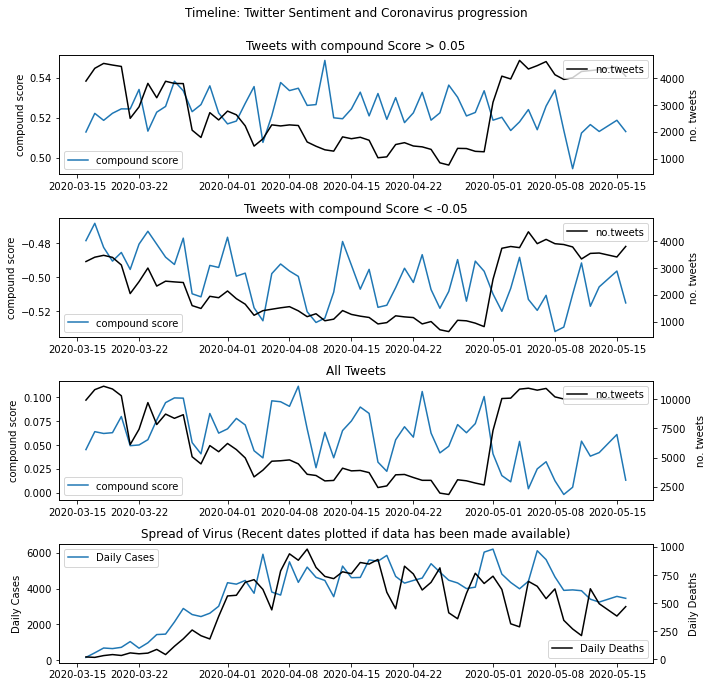

In [270]:
'''Group Sentiment Data by Date and plot alongside no.cases'''

start_date = '2020-03-16' # Choose date to start plotting from
score = 'compound' # Choose sentiment metric
pos_threshold = 0.05 # Choose threshold for positive valence
neg_threshold = -0.05 # Choose threshold for negative valence

'''Filter for valences to plot'''
tweets_pos_valence = tweets[(tweets['{}'.format(score)]>pos_threshold)]
tweets_neg_valence = tweets[(tweets['{}'.format(score)]<neg_threshold)]

'''Merge with no.cases data'''
tweets_pos_valence = tweets_pos_valence.set_index('date').groupby(tweets_pos_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_neg_valence = tweets_neg_valence.set_index('date').groupby(tweets_neg_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_all_valence = tweets.set_index('date').groupby(tweets.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})

cases_plt = cases.set_index('DateVal')
cases_plt['DailyCases_shifted_1'] = cases_plt.DailyCases.shift(1)
cases_plt['DailyDeaths_shifted_1'] = cases_plt.DailyDeaths.shift(1)

tweets_pos_valence = pd.merge(tweets_pos_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_neg_valence = pd.merge(tweets_neg_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_all_valence = pd.merge(tweets_all_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

'''Filter for dates to plot'''
tweets_pos_valence = tweets_pos_valence[tweets_pos_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_neg_valence = tweets_neg_valence[tweets_neg_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_all_valence = tweets_all_valence[tweets_all_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]

'''Plot'''
fig, ax = plt.subplots(figsize=(10,10), sharex=True)
fig.suptitle('Timeline: Twitter Sentiment and Coronavirus progression')

# add subplots to current figure and assign them to variables
ax0 = plt.subplot(411)
ax1 = ax0.twinx()
ax2 = plt.subplot(412)
ax3 = ax2.twinx()
ax4 = plt.subplot(413)
ax5 = ax4.twinx()
ax6 = plt.subplot(414)
ax7 = ax6.twinx()

# share y-axes for no.tweets, and share x-axes for all plots to align dates:
ax1.get_shared_y_axes().join(ax1, ax3)
ax1.get_shared_x_axes().join(ax1, ax3, ax5, ax7)

# Plot data on their respective axes:
ax0.plot(tweets_pos_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax0.set_ylabel('{} score'.format(score))
ax0.legend(loc='lower left')
ax0.set_title('Tweets with {} Score > {}'.format(score,pos_threshold))

ax1.plot(tweets_pos_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax1.set_ylabel('no. tweets')
ax1.legend(loc='upper right')

ax2.plot(tweets_neg_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax2.set_ylabel('{} score'.format(score))
ax2.legend(loc='lower left')
ax2.set_title('Tweets with {} Score < {}'.format(score,neg_threshold))

ax3.plot(tweets_neg_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax3.set_ylabel('no. tweets')
ax3.legend(loc='upper right')

ax4.plot(tweets_all_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax4.set_ylabel('{} score'.format(score))
ax4.legend(loc='lower left')
ax4.set_title('All Tweets')

ax5.plot(tweets_all_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax5.set_ylabel('no. tweets')
ax5.legend(loc='upper right')

ax6.plot(tweets_neg_valence['DailyCases'], label='Daily Cases')
ax6.set_ylabel('Daily Cases')
ax6.legend(loc='upper left')
ax6.set_title('Spread of Virus (Recent dates plotted if data has been made available)')

ax7.plot(tweets_neg_valence['DailyDeaths'], label='Daily Deaths', c='k')
ax7.set_ylabel('Daily Deaths')
ax7.set_ylabel('Daily Deaths')
ax7.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

### Correlations: Sentiment vs Disease Progression
Summary:
- The Correlation matrix below suggests an increase in no.tweets and also higher negative valence as the cases and deaths increased.
- Introducing a 1-day lag increases this correlation, suggesting a lagged effect of the effect on sentiment of the disease
- We also visualise this through scatter plots further below

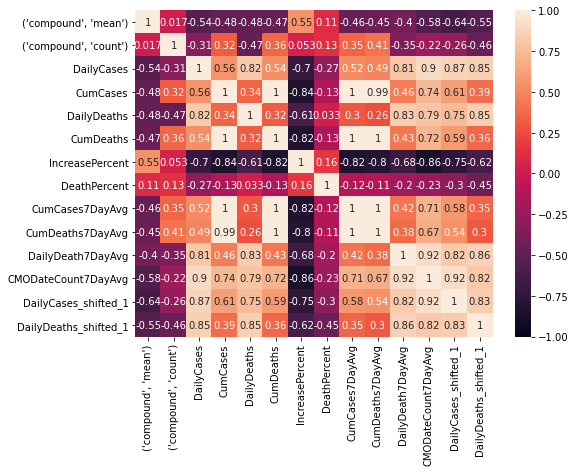

In [248]:
'''HeatMap of Correlations'''
plt.figure(figsize=(8,6))
sns.heatmap(tweets_neg_valence.iloc[1:,:].corr(), vmin=-1, vmax=1, annot=True);

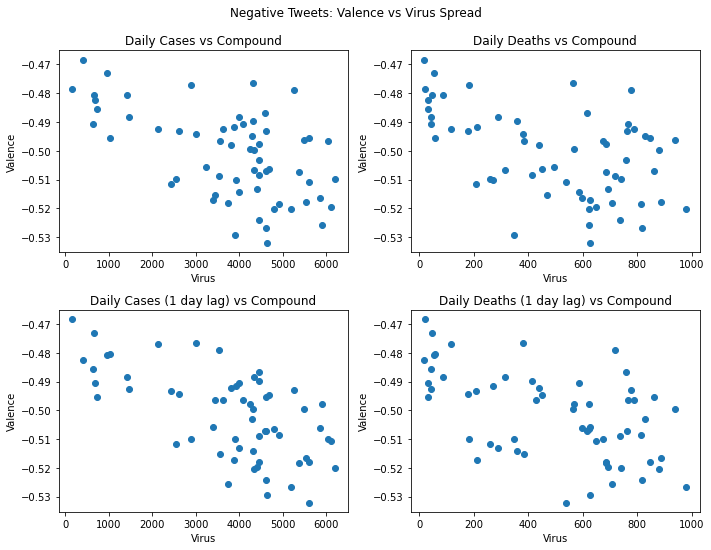

In [245]:
'''Scatter Plots of Valence of Negative Tweets vs Cases and Deaths'''

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.suptitle('Negative Tweets: Valence vs Virus Spread')

ax[0,0].scatter(tweets_neg_valence['DailyCases'],tweets_neg_valence[('compound','mean')])
ax[0,0].set_xlabel('Virus')
ax[0,0].set_ylabel('Valence')
ax[0,0].set_title('Daily Cases vs Compound')

ax[0,1].scatter(tweets_neg_valence['DailyDeaths'],tweets_neg_valence[('compound','mean')])
ax[0,1].set_xlabel('Virus')
ax[0,1].set_ylabel('Valence')
ax[0,1].set_title('Daily Deaths vs Compound')

ax[1,0].scatter(tweets_neg_valence.iloc[1:,-2],tweets_neg_valence.iloc[1:,0])
ax[1,0].set_xlabel('Virus')
ax[1,0].set_ylabel('Valence')
ax[1,0].set_title('Daily Cases (1 day lag) vs Compound')

ax[1,1].scatter(tweets_neg_valence.iloc[1:,-1],tweets_neg_valence.iloc[1:,0])
ax[1,1].set_xlabel('Virus')
ax[1,1].set_ylabel('Valence')
ax[1,1].set_title('Daily Deaths (1 day lag) vs Compound')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

It appears there's some correlation between valence and the disease's progression, let's run a linear regression to assess this:

In [255]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [262]:
def regression_scorer(df, num_rows, x_iloc, y_iloc):
    X = np.array(df.iloc[:num_rows,x_iloc]).reshape(-1,1)
    y = np.array(df.iloc[:num_rows,y_iloc]).reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    pipeline = make_pipeline(StandardScaler(), LinearRegression())
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_test, y_test)

def plot_regression_trend(df, x_iloc, y_iloc):
    num_days_regressed = range(22, len(df)+1)
    scores = [regression_scorer(df, i, x_iloc, y_iloc) for i in num_days_regressed]
    plt.plot(num_days_regressed, scores)
    plt.title('Negative Tweets vs {}'.format(df.columns[x_iloc]))
    plt.xlabel('Num Days in Regression')
    plt.ylabel('Average Valence')

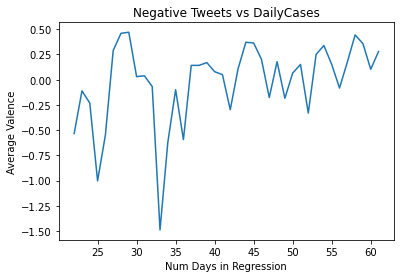

In [263]:
plot_regression_trend(tweets_neg_valence, 2, 0)

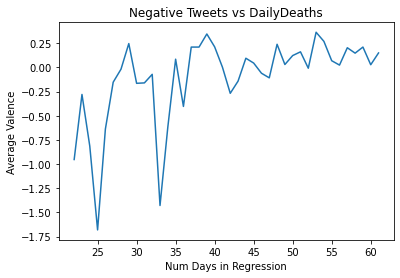

In [264]:
plot_regression_trend(tweets_neg_valence, 4, 0)

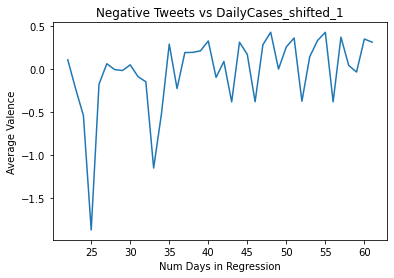

In [265]:
plot_regression_trend(tweets_neg_valence, 12, 0)

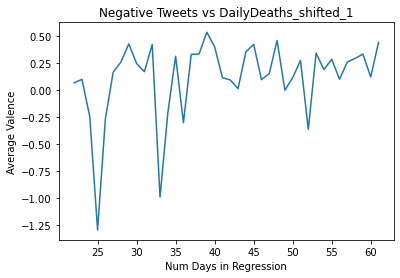

In [266]:
plot_regression_trend(tweets_neg_valence, 13, 0);

##### Conclusion
Above I have plotted the progression in the regression score as I included more days in the model, ie. as the virus progressed:
- At the outset, the regression scores were unstable from one to the day, and often showed values < -1.
- As time passed the behaviour stabilised, however the score oscillated around 0 for all 4 measures of virus progression that I looked at, indicating no strong correlation that we can quantify mathematically.
- Looking again at the trend in virus progression, vs the trend in overall negative sentiment: it's clear to see that despite large swings in the number of cases and deaths, the average valence in negative tweets was relatively unchanged.
- This confirms previous findings that as you zoom out, and include more tweets in your dataset, the sentiment tends to remain stable a at a mean value.
- It's better advised to use sentiment analysis to compare distribution of sentiment for different subsets of the population of the tweets, as we turn to below in Thematic Sentiment

### Thematic Sentiment
- How was sentiment for the government vs nhs, can we infer the public saw these as one and the same, or was there a difference in sentiment towards these two entities? Let's test this statistically.
- What other main talking points emerge over the period? Visualise this in a wordcloud
    - Of these main talking points, who were losers and winners?
    - How did sentiments towards talking points trend over time?
- Which persons or orgs were the big winners and big losers in terms of sentiment?
    - How did sentiments and also num_tweets re: these persons / orgs trend over time?

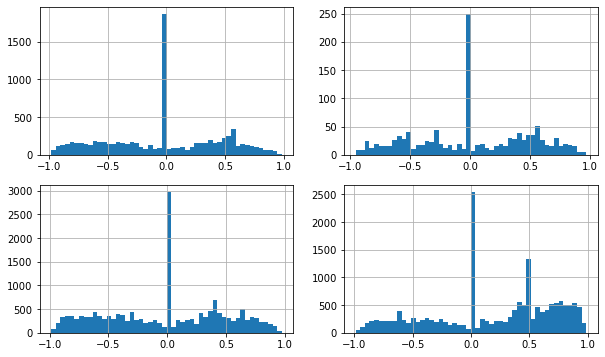

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax = ax.ravel()
tweets[tweets.topical_persons=='johnson']['compound'].hist(ax=ax[0], bins=50)
tweets[tweets.topical_persons=='hancock']['compound'].hist(ax=ax[1], bins=50)
tweets[tweets.topical_orgs=='government']['compound'].hist(ax=ax[2], bins=50)
tweets[tweets.topical_orgs=='nhs']['compound'].hist(ax=ax[3], bins=50);

In [77]:
# Add histograms to show distribution of valences?
# Can you see any relationships worth modelling vs. no. cases?
# Can you wordcloud main topics, and perhaps see the trend in how often they were discussed?
# Also can you see the trend in sentiment for those topics, and trend those too?

# Can you create any hypothesis based on this EDA?